# test glider flight model

In [187]:
import xarray as xr
import numpy as np
import gliderflight


In [125]:
# load timeseries data


ds=xr.open_dataset('./L0-timeseries/wam_sbus_19112025_10122025.nc')

In [160]:
# do this conversion before running the model

import gsw
# 1) Build pressure in dbar from depth (m)
p = gsw.p_from_z(-ds.depth, ds.latitude/100)   # depth positive down

# 2) Convert conductivity to mS/cm if it's in S/m
C_mScm = ds.conductivity * 10.0


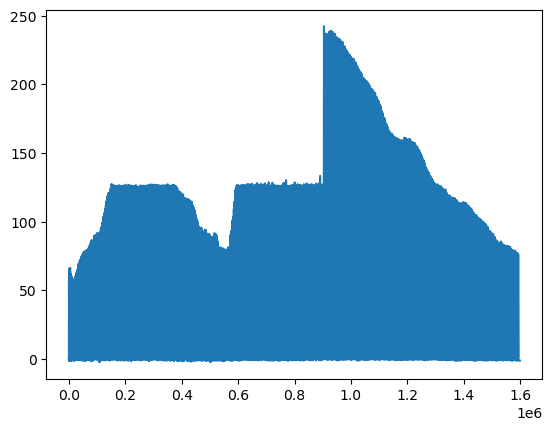

In [161]:
plt.plot(p)

In [162]:
# mask where everything needed is finite
m = np.isfinite(C_mScm) & np.isfinite(ds.temperature) & np.isfinite(p) & np.isfinite(ds.longitude/100) & np.isfinite(ds.latitude/100)

SP = np.full_like(ds.temperature, np.nan, dtype=float)
SA = np.full_like(ds.temperature, np.nan, dtype=float)
rho = np.full_like(ds.temperature, np.nan, dtype=float)

SP[m]  = gsw.SP_from_C(C_mScm[m], ds.temperature[m], p[m])
SA[m]  = gsw.SA_from_SP(SP[m], p[m], (ds.longitude/100)[m], (ds.latitude/100)[m])
rho[m] = gsw.rho_t_exact(SA[m], ds.temperature[m], p[m])


In [163]:
data = dict(time = ds.time_ctd.values[m], pressure=p[m].values/10, pitch = ds.pitch.values[m],
             buoyancy_change=ds.oil_volume.values[m], density=rho[m])

# put pressure in bars 

In [164]:
# convert time to seconds since start, with NaT becoming nan

t = np.asarray(data["time"]).astype("datetime64[ns]")

# find first valid timestamp (not NaT)
good = ~np.isnat(t)
if not np.any(good):
    raise ValueError("All time values are NaT")

t0 = t[good][0]

t_sec = (t - t0) / np.timedelta64(1, "s")
t_sec = t_sec.astype(float)          # NaT becomes nan here 

# clean dict for gliderflight:
m = np.isfinite(t_sec)
data2 = dict(data)
data2["time"] = t_sec[m]
for k in ["pressure", "pitch", "buoyancy_change", "density"]:
    data2[k] = np.asarray(data2[k], dtype=float)[m]


In [165]:

gm = gliderflight.SteadyStateCalibrate(rho0=1024)
gm.set_input_data(**data2)

/Users/xnunei/miniconda3/envs/gliderwork/lib/python3.14/site-packages/gliderflight/gliderflight.py:325: RuntimeWarning: divide by zero encountered in divide
  return -np.gradient(pressure*1e5)/np.gradient(time)/self.RHO0/self.G
/Users/xnunei/miniconda3/envs/gliderwork/lib/python3.14/site-packages/gliderflight/gliderflight.py:325: RuntimeWarning: invalid value encountered in divide
  return -np.gradient(pressure*1e5)/np.gradient(time)/self.RHO0/self.G


In [166]:
condition = np.logical_or((data2["pressure"]*10)<20, (data2["pressure"]*10)>80) #reasonable? 
gm.OR(condition)

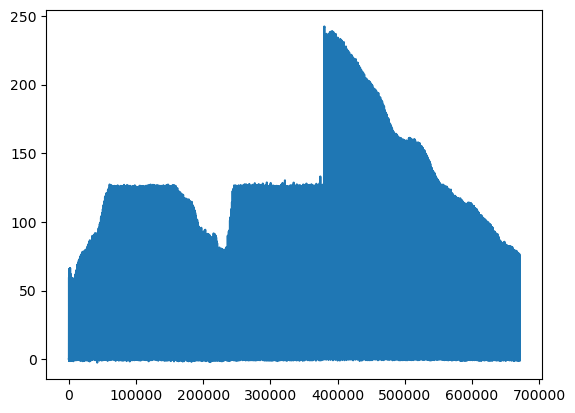

In [167]:
plt.plot(data2["pressure"]*10)

In [168]:
gm.define(mg=78.3, Vg=78.3e-3, Cd0=0.16) # probably not including SUNA
if not gm.undefined_parameters():
    print("We still have undefined parameters...")
    print(gm.undefined_parameters()) # no undefined parameters

We still have undefined parameters...
[]


In [169]:
calibration_result = gm.calibrate("Vg", "Cd0",verbose=True)


/Users/xnunei/miniconda3/envs/gliderwork/lib/python3.14/site-packages/gliderflight/gliderflight.py:643: RuntimeWarning: invalid value encountered in multiply
  self.modelresult = Modelresult(data["time"], ug, wg, U, alpha, pitch, ww, ww*0)


Error: 6.9477700e-02  -  Vg=0.0783  Cd0=0.16
Error: 2.1225973e-01  -  Vg=0.08221  Cd0=0.16
Error: 6.6413805e-02  -  Vg=0.0783  Cd0=0.168
Error: 3.3025027e-02  -  Vg=0.07438  Cd0=0.168
Error: 1.1972195e-01  -  Vg=0.07047  Cd0=0.172
Error: 3.1592389e-02  -  Vg=0.07439  Cd0=0.176
Error: 6.9339874e-02  -  Vg=0.07243  Cd0=0.184
Error: 1.1717240e-01  -  Vg=0.07047  Cd0=0.176
Error: 7.0746660e-03  -  Vg=0.07634  Cd0=0.17
Error: 6.9155673e-03  -  Vg=0.07634  Cd0=0.178
Error: 3.3581905e-02  -  Vg=0.07732  Cd0=0.183
Error: 6.4996175e-02  -  Vg=0.0783  Cd0=0.172
Error: 1.4865732e-02  -  Vg=0.07536  Cd0=0.175
Error: 3.5244133e-02  -  Vg=0.07732  Cd0=0.173
Error: 8.8371798e-03  -  Vg=0.07585  Cd0=0.1745
Error: 2.2149325e-02  -  Vg=0.07683  Cd0=0.1735
Error: 1.2586011e-03  -  Vg=0.0761  Cd0=0.1743
Error: 1.2678385e-03  -  Vg=0.0761  Cd0=0.1823
Error: 8.7532041e-03  -  Vg=0.07585  Cd0=0.1785
Error: 2.0482046e-03  -  Vg=0.07622  Cd0=0.1781
Error: 5.6294326e-03  -  Vg=0.07598  Cd0=0.1784
Error: 1.30195

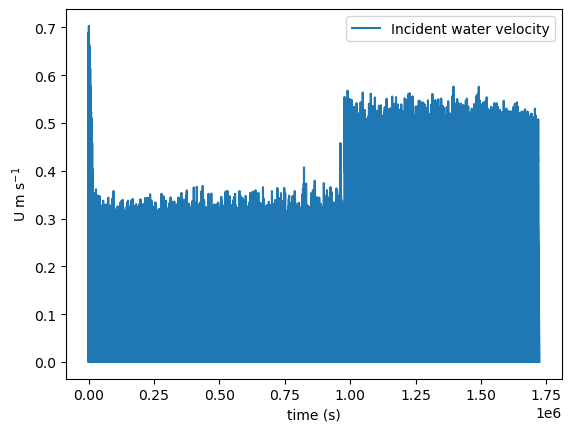

In [170]:
import matplotlib.pyplot as plt

f, ax = plt.subplots(1,1)

ax.plot(gm.t, gm.U, label='Incident water velocity')
ax.set_xlabel('time (s)')
ax.set_ylabel('U m s$^{-1}$')
ax.legend()

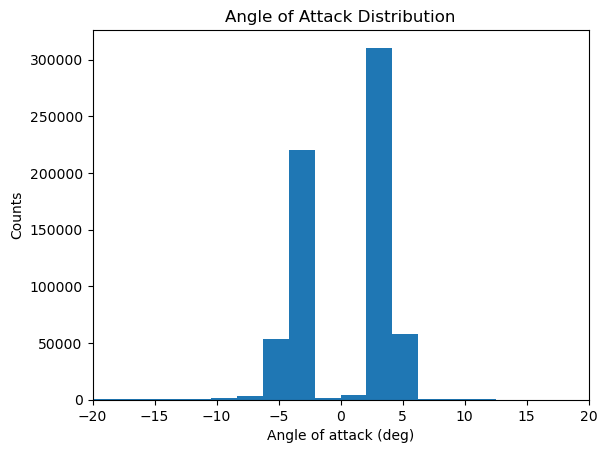

In [171]:
# plot histogram of angle of attack
f, ax = plt.subplots(1,1)
ax.hist(np.rad2deg(gm.alpha), bins=50)
ax.set_xlabel('Angle of attack (deg)')
ax.set_ylabel('Counts')
ax.set_title('Angle of Attack Distribution')
ax.set_xlim(-20,20)
plt.show()  

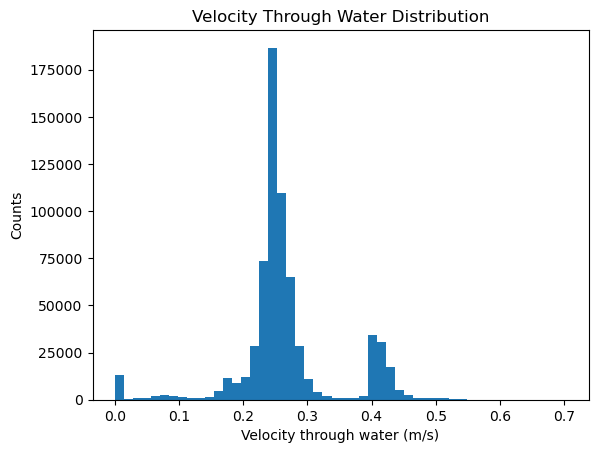

In [172]:
# plot histogram of velocity through water
f, ax = plt.subplots(1,1)
ax.hist(gm.U, bins=50)
ax.set_xlabel('Velocity through water (m/s)')
ax.set_ylabel('Counts')
ax.set_title('Velocity Through Water Distribution')
plt.show()


## Test Dynamic model

In [173]:
fm = gliderflight.DynamicGliderModel(dt=1, rho0=1024, k1=0.02, k2=0.92)
# copy the settings from the steady state model
fm.copy_settings(gm)
fm.max_CPUs = 1
# solution = fm.solve(data2)


# solution is now a named tuple, according to the definition:
# Modelresult = namedtuple("Modelresult", "t u w U alpha pitch ww")

In [174]:
import numpy as np

t = np.asarray(data2["time"], float)
print("time finite:", np.isfinite(t).mean())
dt = np.diff(t)
print("dt min:", dt.min(), "dt median:", np.median(dt))
print("duplicates:", np.sum(dt == 0), "reversals:", np.sum(dt < 0))

for k in ["pressure","pitch","buoyancy_change","density"]:
    a = np.asarray(data2[k], float)
    print(k, "finite:", np.isfinite(a).mean())


time finite: 1.0
dt min: 0.0 dt median: 2.0
duplicates: 26 reversals: 0
pressure finite: 1.0
pitch finite: 1.0
buoyancy_change finite: 1.0
density finite: 1.0


In [175]:
import numpy as np

def clean_for_dynamic(data):
    t = np.asarray(data["time"], float)

    # build finite mask across required vars
    m = np.isfinite(t)
    for k in ["pressure","pitch","buoyancy_change","density"]:
        m &= np.isfinite(np.asarray(data[k], float))

    t = t[m]
    p = np.asarray(data["pressure"], float)[m]
    pitch = np.asarray(data["pitch"], float)[m]
    bc = np.asarray(data["buoyancy_change"], float)[m]
    rho = np.asarray(data["density"], float)[m]
    # dhdt = np.asarray(data["dhdt"], float)[m]

    # sort by time
    idx = np.argsort(t)
    t, p, pitch, bc, rho = t[idx], p[idx], pitch[idx], bc[idx], rho[idx]

    # drop duplicates and enforce strictly increasing time
    keep = np.diff(t, prepend=t[0]-1) > 0
    return dict(time=t[keep], pressure=p[keep], pitch=pitch[keep],
                buoyancy_change=bc[keep], density=rho[keep])

data2c = clean_for_dynamic(data2)
solution = fm.solve(data2c)


In [176]:
solution

Modelresult(t=array([0.00000000e+00, 2.00000000e+00, 4.00000000e+00, ...,
       1.72336856e+06, 1.72337056e+06, 1.72337656e+06], shape=(671317,)), u=array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
       -2.71261158e-09,  2.24243103e-08,  2.66006054e-08], shape=(671317,)), w=array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
       -1.43922707e-09,  1.18976395e-08,  1.41134513e-08], shape=(671317,)), U=array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
       3.07077126e-09, 2.53851043e-08, 3.01128165e-08], shape=(671317,)), alpha=array([ 0.36096284,  0.37154294,  0.38212304, ..., -2.61015688,
        0.53143577,  0.53143577], shape=(671317,)), pitch=array([-0.36096284, -0.37154294, -0.38212304, ..., -0.04363323,
       -0.04363323, -0.04363323], shape=(671317,)), ww=array([ 0.04981443,  0.01743505, -0.01494433, ...,  0.01245805,
       -0.00125446,  0.00330882], shape=(671317,)), depth=array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,


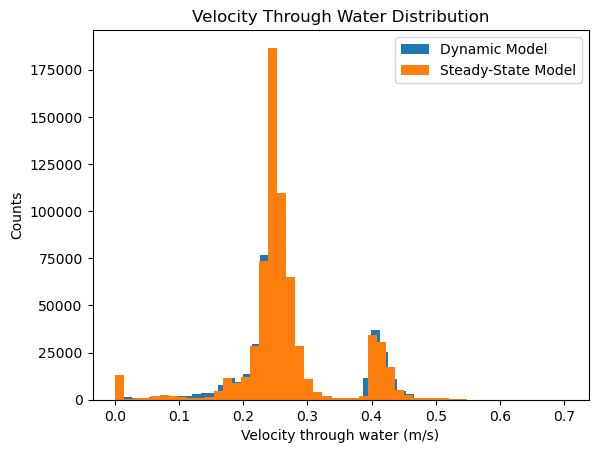

In [186]:
# plot histogram of velocity through water
f, ax = plt.subplots(1,1)
ax.hist(solution.U, bins=50,label='Dynamic Model')
ax.hist(gm.U, bins=50,label='Steady-State Model'        )
ax.legend()
ax.set_xlabel('Velocity through water (m/s)')
ax.set_ylabel('Counts')
ax.set_title('Velocity Through Water Distribution')
plt.show()


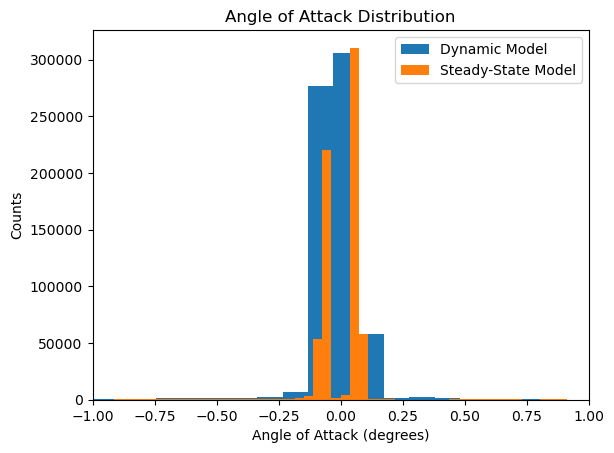

In [185]:
# plot histogram of aoa and add legends for each histogram


f, ax = plt.subplots(1,1)
ax.hist(solution.alpha, bins=50,label='Dynamic Model')
ax.hist(gm.alpha, bins=50,label='Steady-State Model')
ax.set_xlim(-1,1)

ax.legend()
ax.set_xlabel('Angle of Attack (degrees)')
ax.set_ylabel('Counts')
ax.set_title('Angle of Attack Distribution')
plt.show()
